#### Data Handling (example 02)

In [1]:
import memocell as me
import numpy as np
import matplotlib.pyplot as plt

/Users/m651s/Documents/Studium/PhD/01_projects/memo_cell/memocell/memocell/selection.py:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


TODO:

- mention basic idea: net + data -> inference (estimation class and select_models method)
- load by count data
- load by summary data directly (maybe present this for mean only mode)
- use N stochastic simulations by memocell to construct in silico data
- we need a small light weight data set that could be used for the inference example (?!), maybe combine this with the manual defined count data set?

should include: counts and summary; mean only data for summary
also use multiple gillespie runs in silico (also to have that code snippet)

##### create *in silico* data from a ground truth model

MemoCell data objects can be created based on a set of stochastic simulations from a known model. Such *in silico* data can be very helpful to find out what information is contained *in principle* in the data to address the questions of interest (as one can work with a "perfect" data set with a high number of simulation repeats that are typically not feasible in real experiments). More data does not always mean that everything can be inferred; there may always be structurally unidentifiable features!

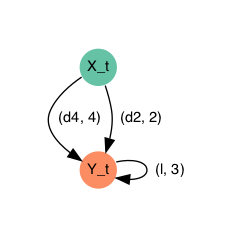

In [27]:
# we use the same model as in example 01 for network definition and simulations (see there for more details)
topology = [
    {'start': 'X_t', 'end': 'Y_t', 'rate_symbol': 'd4', 'type': 'S -> E', 'reaction_steps': 4},
    {'start': 'X_t', 'end': 'Y_t', 'rate_symbol': 'd2', 'type': 'S -> E', 'reaction_steps': 2},
    {'start': 'Y_t', 'end': 'Y_t', 'rate_symbol': 'l', 'type': 'S -> S + S', 'reaction_steps': 3}
    ]

net = me.Network('net_true')
net.structure(t)

me.plots.net_main_plot(net);

In [25]:
# run many stochastic realisations of the ground truth model
# from which in silico data is obtained in the next step

# simulation repeats 
# (pretending a high number of experimental repeats)
num_iter = 100 

variables = {'X_t': ('X_t', ), 'Y_t': ('Y_t', )}
theta_values = {'l': 0.06, 'd4': 0.03, 'd2': 0.04}
time_values = np.linspace(0.0, 54.0, num=14)
initial_values_type = 'synchronous'
initial_values_gillespie = {'X_t': 1, 'Y_t': 0}

# append each stochastic simulation to a list
sim = me.Simulation(net)
res_list = list()
for __ in range(num_iter):
    res_list.append(sim.simulate('gillespie', variables, theta_values, time_values,
            initial_values_type, initial_gillespie=initial_values_gillespie)[1])

# convert to array and check the shape
# count data requires shape (#repeats, #variables, #time points)
sim_res = np.array(res_list)
print(sim_res.shape)

(100, 2, 14)


In [20]:
# load count data with memocell which is automatically 
# processed to summary statistics of mean, 
# variance and covariance with standard errors
data_in_sil = me.Data('data_in_silico')
data_in_sil.load(['X_t', 'Y_t'], time_values, sim_res)

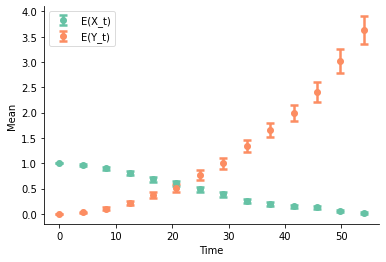

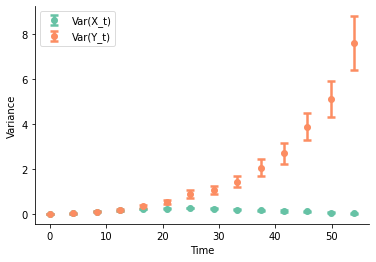

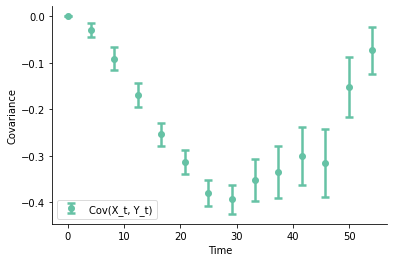

In [21]:
# plot the summary statistics
me.plots.data_mean_plot(data_in_sil)
me.plots.data_variance_plot(data_in_sil)
me.plots.data_covariance_plot(data_in_sil);

In [22]:
# NOTE: the code snippets below can be used to save and 
# then subsequently load the memocell data object for all 
# future inferences

# with open('some_folder/my_in_silico_data.pickle', 'wb') as file_:
#     pickle.dump(data_in_sil, file_)

# data_in_sil = pickle.load(open('some_folder/my_in_silico_data.pickle', 'rb'))